In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 1)

    def forward(self, input, future = 0, seq_len = 32):
        outputs = []
        h_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            output = self.linear(h_t)
            outputs += [output]
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [9]:
import os

def make_data(directory="./train_data"):
    xTr = []
    yTr = []
    for filename in os.listdir(directory):
        beats = np.load(directory + os.sep + filename)
        x, y = split_data(beats)
        xTr.append(x)
        yTr.append(y)
    xTr = np.concatenate(np.array(xTr))
    yTr = np.concatenate(np.array(yTr))
    return xTr, yTr
    
    
def split_data(beats, data_len=32):
    end = beats.shape[0]- (beats.shape[0]%(2*data_len))
    beats = beats[:end].reshape(-1, 2*data_len)
    x, y = beats[:,:32], beats[:,32:]
    return x, y

In [10]:
xTr, yTr = make_data()
print(xTr.shape, yTr.shape)

(9861, 32) (9861, 32)


In [11]:
n_epochs = 1000
lr = 0.1
momentum = 0.9
weight_decay = 1e-4
nesterov = True

# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)

# load data and make training set
input = torch.from_numpy(xTr[:1000]).double()
target = torch.from_numpy(yTr[:1000]).double()
test_input = input[:100]
test_target = target[:100]

# build the model
seq = Sequence()
seq.double()
criterion = nn.MSELoss()

optimizer = optim.SGD(seq.parameters(), lr=lr, momentum=momentum, nesterov=nesterov, weight_decay=weight_decay)

losses = []

#begin to train
for i in range(n_epochs):
    print('STEP: ', i)
    
    def closure():
        optimizer.zero_grad()
        out = seq(input)
        loss = criterion(out, target)
        print('loss:', loss.item())
        loss.backward()
        return loss
    
    optimizer.step(closure)
    
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        future = 32
        pred = seq(test_input, future=future)
        loss = criterion(pred[:, :-future], test_target)
        print('test loss:', loss.item())
        y = pred.detach().numpy()
        losses.append(loss)
        
    # draw the result
    if i % 10 == 0:
        plt.figure(figsize=(30,10))
        plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
        plt.xlabel('x', fontsize=20)
        plt.ylabel('y', fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        def draw(yi, color):
            plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
            plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
        draw(y[0], 'r')
        draw(y[1], 'g')
        draw(y[2], 'b')
        plt.savefig('predict%d.png'%i, bbox_inches='tight')
        plt.close()


STEP:  0
loss: 0.10727303510896695
test loss: 0.10796947738200849
STEP:  1
loss: 0.1071526081953708
test loss: 0.10780587471215781
STEP:  2
loss: 0.10698275826256122
test loss: 0.10759977133457245
STEP:  3
loss: 0.10676818592580439
test loss: 0.107354934241635
STEP:  4
loss: 0.1065127904819715
test loss: 0.10707494092054311
STEP:  5
loss: 0.10622037695990272
test loss: 0.10676322110497093
STEP:  6
loss: 0.10589464184025878
test loss: 0.10642281591632491
STEP:  7
loss: 0.1055388798565359
test loss: 0.10605626234537655
STEP:  8
loss: 0.10515583345035137
test loss: 0.10566566589108001
STEP:  9
loss: 0.10474775167421073
test loss: 0.10525282248210761
STEP:  10
loss: 0.10431651631132384
test loss: 0.10481928010659751
STEP:  11
loss: 0.10386371847958939
test loss: 0.1043663376013991
STEP:  12
loss: 0.10339067554288527
test loss: 0.10389503075995302
STEP:  13
loss: 0.10289843267070048
test loss: 0.10340614029830553
STEP:  14
loss: 0.10238778054964788
test loss: 0.10290022192744694
STEP:  15
l

loss: 0.05657308724283682
test loss: 0.05732684456754123
STEP:  123
loss: 0.05654234747737378
test loss: 0.05725622750017673
STEP:  124
loss: 0.056512508178661006
test loss: 0.0571871044506817
STEP:  125
loss: 0.056483535803723534
test loss: 0.057119430415661504
STEP:  126
loss: 0.05645539886523092
test loss: 0.05705316245823605
STEP:  127
loss: 0.05642806787878952
test loss: 0.0569882597228755
STEP:  128
loss: 0.05640151527636554
test loss: 0.05692468340797483
STEP:  129
loss: 0.05637571529473196
test loss: 0.05686239670568785
STEP:  130
loss: 0.05635064384685153
test loss: 0.05680136471743435
STEP:  131
loss: 0.05632627838296442
test loss: 0.05674155435237185
STEP:  132
loss: 0.05630259774718038
test loss: 0.05668293421500131
STEP:  133
loss: 0.05627958203435394
test loss: 0.05662547448707993
STEP:  134
loss: 0.05625721245106525
test loss: 0.05656914680801053
STEP:  135
loss: 0.056235471183632965
test loss: 0.0565139241570453
STEP:  136
loss: 0.05621434127538553
test loss: 0.05645978

loss: 0.055530411694257015
test loss: 0.054017835136431616
STEP:  243
loss: 0.05552928388637604
test loss: 0.05401046710878871
STEP:  244
loss: 0.05552817898812515
test loss: 0.0540032286500676
STEP:  245
loss: 0.055527096283297606
test loss: 0.05399611735835316
STEP:  246
loss: 0.05552603507831506
test loss: 0.05398913087721717
STEP:  247
loss: 0.05552499470151311
test loss: 0.0539822668948441
STEP:  248
loss: 0.055523974502502835
test loss: 0.05397552314317653
STEP:  249
loss: 0.05552297385148642
test loss: 0.053968897397078275
STEP:  250
loss: 0.05552199213867421
test loss: 0.053962387473519745
STEP:  251
loss: 0.05552102877363057
test loss: 0.053955991230774096
STEP:  252
loss: 0.05552008318471392
test loss: 0.053949706567632996
STEP:  253
loss: 0.05551915481848516
test loss: 0.05394353142263684
STEP:  254
loss: 0.055518243139143476
test loss: 0.053937463773320225
STEP:  255
loss: 0.05551734762800238
test loss: 0.053931501635473354
STEP:  256
loss: 0.05551646778295121
test loss: 0.

loss: 0.0554614075343949
test loss: 0.053637919083425134
STEP:  363
loss: 0.05546103142627697
test loss: 0.053636863272373166
STEP:  364
loss: 0.0554606563639548
test loss: 0.05363582194772997
STEP:  365
loss: 0.05546028233260286
test loss: 0.053634794853037314
STEP:  366
loss: 0.055459909317847576
test loss: 0.05363378173649922
STEP:  367
loss: 0.05545953730572894
test loss: 0.053632782350897926
STEP:  368
loss: 0.05545916628270177
test loss: 0.05363179645350844
STEP:  369
loss: 0.05545879623561783
test loss: 0.05363082380602084
STEP:  370
loss: 0.05545842715172714
test loss: 0.053629864174456546
STEP:  371
loss: 0.055458059018633314
test loss: 0.05362891732909274
STEP:  372
loss: 0.05545769182430315
test loss: 0.053627983044381995
STEP:  373
loss: 0.055457325557072515
test loss: 0.0536270610988793
STEP:  374
loss: 0.0554569602056031
test loss: 0.053626151275167296
STEP:  375
loss: 0.05545659575887311
test loss: 0.05362525335978061
STEP:  376
loss: 0.05545623220619561
test loss: 0.053

loss: 0.05542157897359468
test loss: 0.053569112772391174
STEP:  483
loss: 0.0554212826579598
test loss: 0.05356879364317892
STEP:  484
loss: 0.05542098685278536
test loss: 0.05356847648113833
STEP:  485
loss: 0.05542069155708126
test loss: 0.05356816125827951
STEP:  486
loss: 0.0554203967698766
test loss: 0.05356784794712545
STEP:  487
loss: 0.05542010249021559
test loss: 0.053567536520703035
STEP:  488
loss: 0.05541980871714673
test loss: 0.05356722695253411
STEP:  489
loss: 0.055419515449738006
test loss: 0.05356691921662622
STEP:  490
loss: 0.05541922268706541
test loss: 0.05356661328746314
STEP:  491
loss: 0.055418930428212256
test loss: 0.05356630913999539
STEP:  492
loss: 0.0554186386722836
test loss: 0.05356600674963378
STEP:  493
loss: 0.055418347418382224
test loss: 0.053565706092238104
STEP:  494
loss: 0.055418056665630426
test loss: 0.05356540714411162
STEP:  495
loss: 0.05541776641315446
test loss: 0.05356510988199082
STEP:  496
loss: 0.05541747666009486
test loss: 0.05356

loss: 0.05538945310846721
test loss: 0.05353989155006734
STEP:  603
loss: 0.05538921296350576
test loss: 0.05353969890200032
STEP:  604
loss: 0.055388973251756804
test loss: 0.05353950684050862
STEP:  605
loss: 0.05538873397270173
test loss: 0.05353931536211729
STEP:  606
loss: 0.05538849512580858
test loss: 0.053539124463402865
STEP:  607
loss: 0.055388256710562446
test loss: 0.05353893414099089
STEP:  608
loss: 0.05538801872643841
test loss: 0.05353874439155619
STEP:  609
loss: 0.055387781172913486
test loss: 0.05353855521182067
STEP:  610
loss: 0.0553875440494653
test loss: 0.05353836659855391
STEP:  611
loss: 0.05538730735557225
test loss: 0.05353817854857046
STEP:  612
loss: 0.0553870710907126
test loss: 0.05353799105873118
STEP:  613
loss: 0.05538683525436669
test loss: 0.05353780412593987
STEP:  614
loss: 0.05538659984600709
test loss: 0.05353761774714352
STEP:  615
loss: 0.05538636486511624
test loss: 0.053537431919332204
STEP:  616
loss: 0.05538613031116542
test loss: 0.053537

loss: 0.055363580995591535
test loss: 0.05352026476654839
STEP:  723
loss: 0.055363389055911254
test loss: 0.053520126358298344
STEP:  724
loss: 0.05536319748509096
test loss: 0.05351998830785889
STEP:  725
loss: 0.05536300628256996
test loss: 0.05351985061405041
STEP:  726
loss: 0.0553628154478015
test loss: 0.05351971327569745
STEP:  727
loss: 0.05536262498021505
test loss: 0.05351957629162793
STEP:  728
loss: 0.05536243487925477
test loss: 0.05351943966067509
STEP:  729
loss: 0.05536224514436039
test loss: 0.05351930338167553
STEP:  730
loss: 0.05536205577496942
test loss: 0.053519167453470365
STEP:  731
loss: 0.05536186677052056
test loss: 0.05351903187490399
STEP:  732
loss: 0.05536167813045398
test loss: 0.05351889664482503
STEP:  733
loss: 0.055361489854211195
test loss: 0.05351876176208645
STEP:  734
loss: 0.05536130194122651
test loss: 0.05351862722554396
STEP:  735
loss: 0.055361114390935606
test loss: 0.05351849303405718
STEP:  736
loss: 0.05536092720277847
test loss: 0.0535

loss: 0.05534302266563256
test loss: 0.053505903913555294
STEP:  843
loss: 0.0553428709274649
test loss: 0.05350580080258108
STEP:  844
loss: 0.05534271948957667
test loss: 0.053505697925625484
STEP:  845
loss: 0.05534256835138441
test loss: 0.053505595281753714
STEP:  846
loss: 0.05534241751232022
test loss: 0.05350549287003368
STEP:  847
loss: 0.05534226697180526
test loss: 0.05350539068953293
STEP:  848
loss: 0.0553421167292717
test loss: 0.05350528873932137
STEP:  849
loss: 0.05534196678413773
test loss: 0.05350518701846955
STEP:  850
loss: 0.05534181713584008
test loss: 0.053505085526050294
STEP:  851
loss: 0.05534166778380189
test loss: 0.05350498426113673
STEP:  852
loss: 0.05534151872744601
test loss: 0.05350488322280353
STEP:  853
loss: 0.05534136996620478
test loss: 0.05350478241012775
STEP:  854
loss: 0.055341221499499216
test loss: 0.05350468182218607
STEP:  855
loss: 0.055341073326766306
test loss: 0.0535045814580581
STEP:  856
loss: 0.05534092544742591
test loss: 0.053504

loss: 0.05532679880216305
test loss: 0.05349495040673959
STEP:  963
loss: 0.05532667907278063
test loss: 0.05349486909980609
STEP:  964
loss: 0.05532655957697542
test loss: 0.05349478792502908
STEP:  965
loss: 0.05532644031420843
test loss: 0.05349470688165661
STEP:  966
loss: 0.055326321283963635
test loss: 0.053494625968937594
STEP:  967
loss: 0.055326202485710164
test loss: 0.053494545186122344
STEP:  968
loss: 0.05532608391892379
test loss: 0.05349446453246326
STEP:  969
loss: 0.055325965583069986
test loss: 0.05349438400721549
STEP:  970
loss: 0.055325847477636206
test loss: 0.05349430360963413
STEP:  971
loss: 0.05532572960209257
test loss: 0.053494223338977596
STEP:  972
loss: 0.05532561195590975
test loss: 0.05349414319450453
STEP:  973
loss: 0.05532549453857712
test loss: 0.0534940631754778
STEP:  974
loss: 0.05532537734955698
test loss: 0.05349398328115881
STEP:  975
loss: 0.05532526038833973
test loss: 0.05349390351081336
STEP:  976
loss: 0.05532514365439778
test loss: 0.053

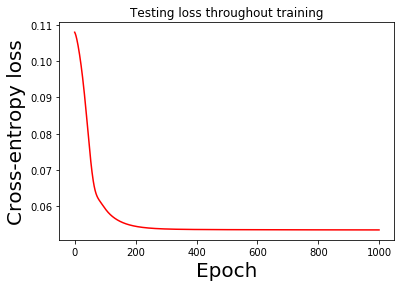

In [14]:
%matplotlib inline

losses = np.array(losses)
plt.plot(losses, 'r')
plt.title('Testing loss throughout training')
plt.ylabel('Cross-entropy loss', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.savefig('loss_1000epochs.png', bbox_inches='tight')